In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import k3d
import matplotlib.pyplot as plt
from sloppy.optic import *
from sloppy.raytracing import *
from sloppy.abcd import *
from sloppy.utils import *
from sloppy.tools import *

In [4]:
import matplotlib.colors as mcolors

In [ ]:
k3d.docs.

In [57]:
def LensCavML(flong=100.0, fmla=6.0, eps_grin=0.1, eps_long=-4.2, eps_mirr=-4.0, eps_mirr2=0, eps_mla=0.05, lens_diam=25.4, grin_diam=2.4, grin_thick=1.020, lens_thick=6.0, mla_thick=4.0):
    
    wdgrin = 0.8
    fgrin=1.5
    
    p_grin_f = wdgrin + eps_grin
    p_grin_b = p_grin_f + grin_thick
    p_long_f = p_grin_b + fgrin + flong + eps_long
    p_long_b = p_long_f + lens_thick
    p_mla_f = p_long_b + flong + eps_mla
    p_mla_b = p_mla_f + mla_thick 
    p_mirr = p_long_b + flong + eps_mirr
    p_mirr_mla = p_mla_b + fmla + eps_mirr2 - eps_mla
    
    p00 = np.array([0,0,0])
    p0 = np.array([0,0,p_grin_f])
    p1 = np.array([0,0,p_grin_b])
    p2 = np.array([0,0,p_long_f])
    p3 = np.array([0,0,p_long_b])
    p3b = np.array([0,0,p_mla_f])
    p3c = np.array([0,0,p_mla_b])
    p4 = np.array([0,0,p_mirr_mla])

    pm0 = np.array([0,0,-p_grin_f])
    pm1 = np.array([0,0,-p_grin_b])
    pm2 = np.array([0,0,-p_long_f])
    pm3 = np.array([0,0,-p_long_b])
    pm4 = np.array([0,0,-p_mirr])

    e = np.array([0,0,5.0])*0
    
    ii = lens_diam
    hi = 12.7
    qi=7.75
    ng = 1.4537

    # Rgrin = (ng-1)*fgrin
    Rlong = (ng-1)*flong
    # now C140 instead of "spherical" GRIN lens
    Rgrin = -0.840660
    k=-0.963070
    An=[-9.476566e-2, -2.790461e-2, -5.415580e-3, -3.553653e-3]
    Rmla = (ng-1)*fmla
    
    coeff = np.array([Rgrin, k,] + An) #these coefficients go _away_ from the normal
    coeffm = coeff*-1 #these coefficients go _to_ the normal
    coeffm[1] = k
    
    nz = (0., 0. ,-1.0)
    nzm = (0., 0. ,1.0)
    axz = (-1, 0, 0)
    axzm = (1, 0, 0)

    screen = Screen(n=nzm, ax=axzm)
    screen2 = Screen(n=nzm, ax=axzm)

    mla = MicroLensArray(
        p=p3c,         # Position at z=10
        n=nz,          # Normal in +z direction
        ax=axz,
        diameter=ii,        # 10mm overall diameter 
        R=-Rmla,                # 0.5mm radius of curvature for each lenslet
        curv='CC',            # Concave lenslets
        n1=ng,               # Air on incident side
        n2=1.0,               # Glass on exit side
        a1=(0.5, 0),          # 100µm spacing in x
        a2=(0, 0.5),          # 100µm spacing in y
        origin_centered=True  # Center the first lenslet at the origin
    )

    
    # negative sign of first cuved surface for abcd matrix
    elements_r = [
                Glass(p=p0, n=nz, ax=axz, diameter=grin_diam, n2=ng),
                ThorlabsAsphere(p=p1, n=nz, ax=axz, diameter=grin_diam, n1=ng, coef=coeffm), #R=-Rgrin,
                Glass(p=p2, n=nz, ax=axz, diameter=ii, n2=ng),
                CurvedGlass(p=p3, n=nz, ax=axz, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                Glass(p=p3b, n=nz, ax=axz, diameter=ii, n2=ng),
                mla,
                ]

    elements_l = [Glass(p=pm0, n=nzm, ax=axzm, diameter=grin_diam, n2=ng),
                ThorlabsAsphere(p=pm1, n=nzm, ax=axzm, diameter=grin_diam, n1=ng, coef=coeffm),
                Glass(p=pm2, n=nzm, ax=axzm, diameter=ii, n2=ng),
                CurvedGlass(p=pm3, n=nzm, ax=axzm, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                ]
    screenmirr = Screen(p=p4, n=nz, ax=axz)
    # return [screen, *elements_r, Mirror(p=p4, n=nz, ax=axz, diameter=ii), *(elements_r[::-1]), screen2]#*elements_l, Mirror(p=pm4, n=nzm, ax=axzm, diameter=ii), *(elements_l[::-1]), screen2]
    return [screenmirr, *(elements_r[::-1]), *elements_l, Mirror(p=pm4, n=nzm, ax=axzm, diameter=ii), *(elements_l[::-1]), *(elements_r), screenmirr]#, screen2]

In [43]:
def source_MLA_bundle(Nx=2, Ny=None, Nsx=5, Nsy=None, dx=0.5, dy=None, sx=1e-3, sy=None, Nex=0, Ney=None, ex=0, ey=None):
    if Ny is None:
        Ny = Nx

    if Nsy is None:
        Nsy = Nsx

    if dy is None:
        dy = dx

    if sy is None:
        sy = sx

    if Ney is None:
        Ney = Nex

    if ey is None:
        ey = ex

    # make iterators for x and y displacements and slopes and little epsilon displacements around MLA positions
    it_x = np.linspace(-dx*Nx, dx*Nx, 2*Nx+1) if Nx>0 else np.array([0])
    it_y = np.linspace(-dy*Ny, dy*Ny, 2*Ny+1) if Ny>0 else np.array([0])
    it_sx = np.linspace(-sx*Nsx, sx*Nsx, 2*Nsx+1) if Nsx>0 else np.array([0])
    it_sy = np.linspace(-sy*Nsy, sy*Nsy, 2*Nsy+1) if Nsy>0 else np.array([0])
    it_ex = np.linspace(-ex*Nex, ex*Nex, 2*Nex+1) if Nex>0 else np.array([0])
    it_ey = np.linspace(-ey*Ney, ey*Ney, 2*Ney+1) if Ney>0 else np.array([0])

    # iterate over all combinations of the iterators using itertools.product and make a bundle id for every x and y location
    mus = np.stack([[x+ex, y+ey, sx, sy] for x in it_x for y in it_y for sx in it_sx for sy in it_sy for ex in it_ex for ey in it_ey], axis=0)
    bundle_ids = np.stack([[i, j] for i, x in enumerate(it_x) for j, y in enumerate(it_y) for k, sx in enumerate(it_sx) for l, sy in enumerate(it_sy) for m, ex in enumerate(it_ex) for n, ey in enumerate(it_ey)], axis=0)


    return mus, bundle_ids

In [81]:
# elements = LensCavML(eps_long=-4.2+0.5, eps_grin=0, eps_mla=0.0, eps_mirr2=0)
# elements = LensCavML(eps_long=-4.2, eps_grin=0.2+0.05*3, eps_mla=3.0, eps_mirr2=0)
elements = LensCavML(**sliders_dict)
# elements = sysMLA()
screen = elements[0]
sys = RaySystem(elements, add_screen=False)
sys.screen = screen

Mag = 6/100.0

mu, bundle_id = source_MLA_bundle(Nx=2, Ny=0, Nsx=2, Nsy=0, dx=0.5, sx=1e-3, Nex=1, ex=1e-4)
# make the (i,j) bundle id a 1d array by adding i+j*Nx for every i,j pair
Nx = len(np.unique(bundle_id[:,0]))
bundle_ids = bundle_id[:,0] + bundle_id[:,1]*Nx

N = len(np.unique(bundle_ids))
viridis = plt.cm.viridis

# Extract N evenly spaced colors from viridis
colors = viridis(np.linspace(0, 1, N))

ray = sys.screen.eigenvectors_to_rays(mu)
traj = sys.propagate(ray, at_screen=False, clip=False)

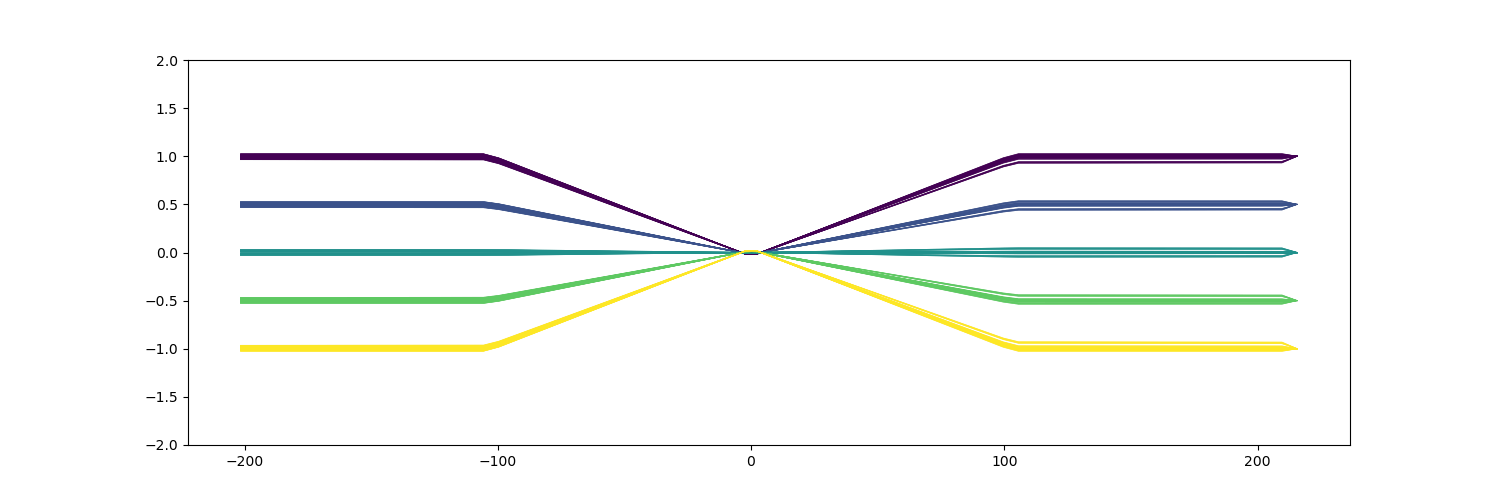

In [82]:
plt.figure(figsize=(15, 5))
for i in range(traj.shape[2]):
    plt.plot(traj[:, 0, i, 2], traj[:, 0, i, 0], color=colors[bundle_ids[i]], alpha=0.5, lw=0.5)
plt.ylim(-2,2)
plt.show()

interactive(children=(FloatSlider(value=-4.2, description='eps_long', layout=Layout(height='30px', width='80%'…

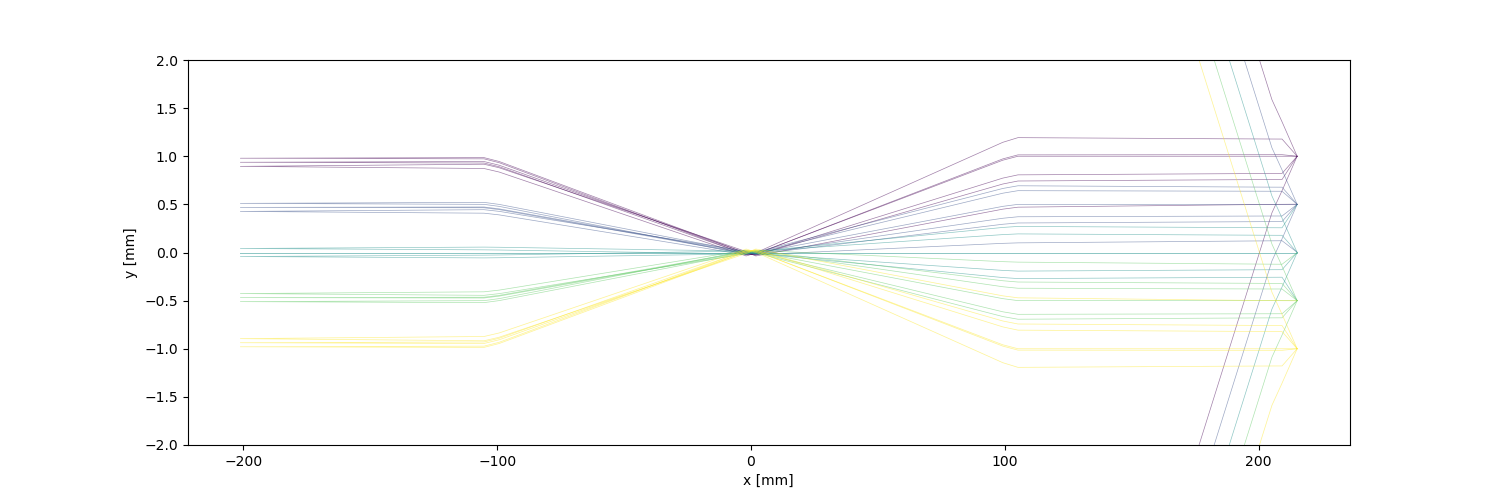

In [70]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 5))
ms = 8.

# now let's make the x-z plot of the rays interactive using ipywidgets
# make the plot
lines = []
for i in range(traj.shape[2]):
    l = plt.plot(traj[:, 0, i, 2], traj[:, 0, i, 0], color=colors[bundle_ids[i]], alpha=0.5, lw=0.5)[0]
    lines.append(l)

plt.ylim(-2,2)



plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

cavfct = LensCavML

def update_xygrid(cavfct, eps_long=-4.2, eps_grin=0.35, eps_mirr2=0, eps_mla=3.0, Nbundle = 3, Narr = 2, div=0.02, **kwargs):
    elements = LensCavML(eps_long=eps_long, eps_grin=eps_grin, eps_mla=eps_mla, eps_mirr2=eps_mirr2)
    # elements = LensCavML()
    screen = elements[0]
    sys = RaySystem(elements, add_screen=False)
    sys.screen = screen
    
    mu, bundle_id = source_MLA_bundle(Nx=2, Ny=0, Nsx=2, Nsy=0, dx=0.5, sx=div, Nex=0)
    # make the (i,j) bundle id a 1d array by adding i+j*Nx for every i,j pair
    Nx = len(np.unique(bundle_id[:,0]))
    bundle_ids = bundle_id[:,0] + bundle_id[:,1]*Nx
    N = len(np.unique(bundle_ids))

    # Extract N evenly spaced colors from viridis
    colors = viridis(np.linspace(0, 1, N))
    
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, at_screen=False, clip=False)
    
    #update the lines
    for i in range(traj.shape[2]):
        lines[i].set_data(traj[:, 0, i, 2], traj[:, 0, i, 0])
    

    fig.canvas.draw_idle()
        
_magnitude = lambda x: 1. if abs(x)<0.1 else int(np.floor(np.log10(abs(x))))
_sgn = lambda x: 1 if x>0 else -1
_min = lambda x: -1 if x==0 else (10*x if x<0 else 0.1*x)
_max = lambda x: 1 if x==0 else (0.1*x if x<0 else 10*x)


lo = Layout(width='80%', height='30px')

sliders = {v.name: FloatSlider(value=v.default, min=_min(v.default), max=_max(v.default), step=10**(_magnitude(v.default)-2), readout_format='.2e', layout=lo) for v in inspect.signature(cavfct).parameters.values() if not v.name.endswith('_thick') }

sliders.update({'Nbundle': IntSlider(value=6, min=1, max=7,  layout=lo)})
sliders.update({'Narr': IntSlider(value=3, min=1, max=7,  layout=lo)})
sliders.update({'div': FloatSlider(value=0.03, min=0, max=0.2, step=0.01, layout=lo)})
interactive(update_xygrid, cavfct=fixed(cavfct), **sliders)
# update_xygrid(cavfct)


In [74]:
# turn the current slider values into a dictionary
sliders_dict = {k: np.round(v.value, 4) for k, v in sliders.items()}
sliders_dict.pop('Nbundle')
sliders_dict.pop('Narr')
sliders_dict.pop('div')
sliders_dict



{'flong': 100.0,
 'fmla': 6.0,
 'eps_grin': 0.146,
 'eps_long': -3.82,
 'eps_mirr': -4.0,
 'eps_mirr2': 0.0,
 'eps_mla': 0.005,
 'lens_diam': 25.44,
 'grin_diam': 2.4}

In [97]:
epsx = 2e-4
epss = 1e-3
mu_eps = np.array([[0, 0, 0, 0],
                [-epsx, 0, 0, 0],
                [epsx, 0, 0, 0],
                [0,-epsx,  0, 0],
                [0, epsx, 0, 0],
                [0, 0, -epss, 0],
                [0, 0, epss, 0],
                [0, 0, 0, -epss],
                [0, 0, 0, epss],
               ], dtype=np.float64)
mu_eps

array([[ 0.    ,  0.    ,  0.    ,  0.    ],
       [-0.0002,  0.    ,  0.    ,  0.    ],
       [ 0.0002,  0.    ,  0.    ,  0.    ],
       [ 0.    , -0.0002,  0.    ,  0.    ],
       [ 0.    ,  0.0002,  0.    ,  0.    ],
       [ 0.    ,  0.    , -0.001 ,  0.    ],
       [ 0.    ,  0.    ,  0.001 ,  0.    ],
       [ 0.    ,  0.    ,  0.    , -0.001 ],
       [ 0.    ,  0.    ,  0.    ,  0.001 ]])

In [98]:
ray_eps = sys.screen.eigenvectors_to_rays(mu_eps)
traj_eps = sys.propagate(ray_eps, at_screen=False, clip=False, Nrt=1)

In [99]:
mu_post = sys.screen.rays_to_eigenvectors(traj_eps[-1,:,:,:])
mu_post

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.01162606e-04,  0.00000000e+00,  1.33000667e-02,
         0.00000000e+00],
       [-2.01162606e-04,  0.00000000e+00, -1.33000667e-02,
         0.00000000e+00],
       [ 0.00000000e+00,  2.01162606e-04,  0.00000000e+00,
         1.33000667e-02],
       [ 0.00000000e+00, -2.01162606e-04,  0.00000000e+00,
        -1.33000667e-02],
       [-8.74608471e-06,  0.00000000e+00,  6.47482663e-04,
         0.00000000e+00],
       [ 8.74608471e-06,  0.00000000e+00, -6.47482663e-04,
         0.00000000e+00],
       [ 0.00000000e+00, -8.74608471e-06,  0.00000000e+00,
         6.47482663e-04],
       [ 0.00000000e+00,  8.74608471e-06,  0.00000000e+00,
        -6.47482663e-04]])

In [105]:
abcd = np.stack([mu_post[2]/epsx, mu_post[4]/epsx, mu_post[6]/epss, mu_post[8]/epss], axis=-1)
# print numpy array with 3 decimal places
np.round(abcd, 4)

array([[-1.00580e+00,  0.00000e+00,  8.70000e-03,  0.00000e+00],
       [ 0.00000e+00, -1.00580e+00,  0.00000e+00,  8.70000e-03],
       [-6.65003e+01,  0.00000e+00, -6.47500e-01,  0.00000e+00],
       [ 0.00000e+00, -6.65003e+01,  0.00000e+00, -6.47500e-01]])

In [106]:
epsr = epsx
epss = epss
mue = np.array([[0, 0, 0, 0], [epsr, 0, 0, 0], [0, epsr, 0, 0], [0, 0, epss, 0], [0, 0, 0, epss]], dtype=np.float64)
guideray = sys.screen.eigenvectors_to_rays(mue)
trajgr = sys.propagate(guideray, Nrt=1, clip=True)
Mfd = sys.screen.rays_to_eigenvectors(trajgr[-1,:,1:,:]) - sys.screen.rays_to_eigenvectors(trajgr[-1,:,0,:][:,None,:])  
Mfd = Mfd.T
Mfd[:2, :] /= epsr
Mfd[2:, :] /= epss*np.inf

In [107]:
np.round(Mfd, 4)

array([[-1.0058,  0.    ,  0.0437,  0.    ],
       [ 0.    , -1.0058,  0.    ,  0.0437],
       [-0.    ,  0.    , -0.    ,  0.    ],
       [ 0.    , -0.    ,  0.    , -0.    ]])

In [74]:
mus = sys.abcd.M2BiK(Mfd)

In [81]:
sys.abcd.is_stable = True

In [82]:
sys.abcd.is_stable 

False

In [79]:
sys.abcd.M2freq(mus, s=1)

([nan, nan], [nan, nan])

In [34]:

L=10
m = np.identity(4, dtype=np.float64)
m[0,2] = L
m[1,3] = L
m

array([[ 1.,  0., 10.,  0.],
       [ 0.,  1.,  0., 10.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [407]:
# elements = LensCavML(eps_long=-4.2+0.5, eps_grin=0, eps_mla=0.0, eps_mirr2=0)
elements = LensCavML()

# elements = sysMLA()
screen = elements[0]
sys = RaySystem(elements, add_screen=False)
sys.screen = screen

Mag = 6/100.0

Nbundle = 3
Narr = 2
div = 0.02
mu = np.stack([[xx, 0., sx, 0.] for xx in np.linspace(-0.5*Narr, 0.5*Narr, 2*Narr+1) for sx in np.linspace(-0.1, 0.1, Nbundle)*div for sy in np.linspace(-0.1, 0.1, Nbundle)*div], axis=0)
bundle_id = np.stack([a for a in np.arange(2*Narr+1) for b in np.arange(Nbundle) for c in np.arange(Nbundle)], axis=0)
viridis = plt.cm.viridis
N = 2*Narr+1
# Extract N evenly spaced colors from viridis
colors = viridis(np.linspace(0, 1, N))

ray = sys.screen.eigenvectors_to_rays(mu)
traj = sys.propagate(ray, at_screen=False, clip=False)

In [408]:
pos = traj[8,0,:,[0,1]].T


Text(0, 0.5, 'y [mm]')

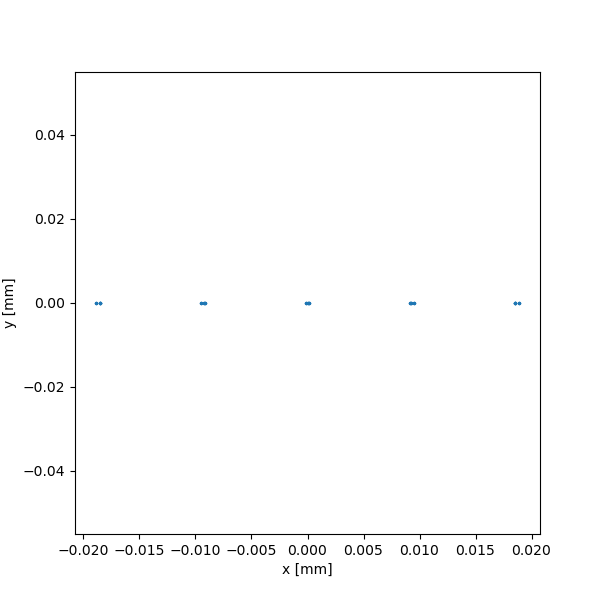

In [409]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
# linea = plt.scatter(xy[:,0], xy[:,1], s=2.)
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')


In [413]:
lineb.get_offsets().data.shape

(45, 2)

interactive(children=(FloatSlider(value=-4.2, description='eps_long', layout=Layout(height='30px', width='80%'…

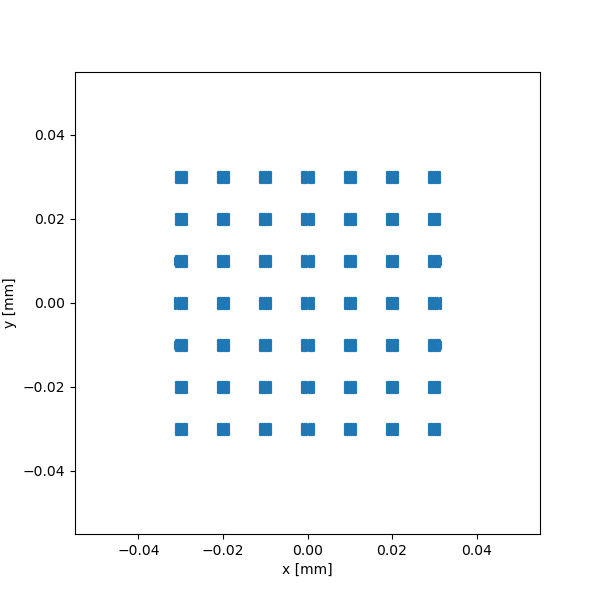

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
# linea = plt.scatter(xy[:,0], xy[:,1], s=2.)
pos = np.zeros((10,2))
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

cavfct = LensCavML

def update_xygrid(cavfct, eps_long=-4.2, eps_grin=0.35, eps_mirr2=0, eps_mla=3.0, Nbundle = 3, Narr = 2, div=0.02, **kwargs):
    elements = LensCavML(eps_long=eps_long, eps_grin=eps_grin, eps_mla=eps_mla, eps_mirr2=eps_mirr2)
    # elements = LensCavML()
    screen = elements[0]
    sys = RaySystem(elements, add_screen=False)
    sys.screen = screen
    
    Mag = 6/100.0
    
    mu = np.stack([[xx, yy, sx, sy] for xx in np.linspace(-0.5*Narr, 0.5*Narr, 2*Narr+1) for yy in np.linspace(-0.5*Narr, 0.5*Narr, 2*Narr+1) for sx in np.linspace(-0.1, 0.1, Nbundle)*div for sy in np.linspace(-0.1, 0.1, Nbundle)*div], axis=0)
    bundle_id = np.stack([a for a in np.arange(2*Narr+1) for b in np.arange(Nbundle) for c in np.arange(Nbundle)], axis=0)
    viridis = plt.cm.viridis
    N = 2*Narr+1
    # Extract N evenly spaced colors from viridis
    colors = viridis(np.linspace(0, 1, N))
    
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, at_screen=False, clip=False)
    # linea.set_offsets(xy)
    pos = traj[8,0,:,[0,1]].T
    lineb.set_offsets(pos)

    fig.canvas.draw_idle()
        
_magnitude = lambda x: 1. if abs(x)<0.1 else int(np.floor(np.log10(abs(x))))
_sgn = lambda x: 1 if x>0 else -1
_min = lambda x: -1 if x==0 else (10*x if x<0 else 0.1*x)
_max = lambda x: 1 if x==0 else (0.1*x if x<0 else 10*x)


lo = Layout(width='80%', height='30px')

sliders = {v.name: FloatSlider(value=v.default, min=_min(v.default), max=_max(v.default), step=10**(_magnitude(v.default)-2), readout_format='.2e', layout=lo) for v in inspect.signature(cavfct).parameters.values() if not v.name.endswith('_thick') }

sliders.update({'Nbundle': IntSlider(value=6, min=1, max=7,  layout=lo)})
sliders.update({'Narr': IntSlider(value=3, min=1, max=7,  layout=lo)})
sliders.update({'div': FloatSlider(value=0.03, min=0, max=0.2, step=0.01, layout=lo)})
interactive(update_xygrid, cavfct=fixed(cavfct), **sliders)
# update_xygrid(cavfct)

In [406]:
plt.close('all')

In [ ]:
try:
    plot.close()
except:
    pass
plot = k3d.plot(camera_auto_fit=True, antialias=True)

for i, el in enumerate(sys.elements):
    if not isinstance(el, Screen):
        plot += el.plot(opacity=0.4)

for i, el in enumerate(sys.elements):
    plot_element_ax(el, plot, length=2.)

# plot_rays(ray, plot)
plot_trajs(traj[0:7], plot)
plot_trajs(traj[6:], plot, color=0x555500)

plot.display()

C:\Users\simonlab\.conda\envs\sloppy\Lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


In [25]:
cavfct = LensCavAsphSimple
parname = 'eps_grin'
res = degeneracy_length(cavfct, parname, 1)
Ldeg = res.x
print(res)
elements = cavfct(**{parname: Ldeg})
sys = RaySystem(elements)
system = sys.abcd
mu1, mu2 = system.q

 message: NaN result encountered.
 success: False
  status: 2
     fun: nan
       x: 0.0
     nit: 1
    nfev: 1


In [10]:
def _cavity_parameter_interaction_factory(cavfct, parname, scanrange, N = 300):
    fig, ax = plt.subplots(ncols=2, figsize=(8,4), sharex=True)
    lws = [ax[0].plot([0, 1], [0, 1])[0] for i in range(2)]
    ax[0].set_ylabel('um')
    lfs = [ax[1].plot([0, 1], [0, 1])[0] for i in range(4)]
    ax[1].set_ylabel('MHz')
    axh1 = ax[1].axhline(0, color='grey')
    axv0 = ax[0].axvline(0, color='grey')
    axv1 = ax[1].axvline(0, color='grey')
    plt.show()
    
    def update_waists_vs_params(cavfct, parname, scanrange, N = 300, **kwargs):
        stab = lambda m: abs(0.5*np.trace(m))<1
        scanrange=[-5, 3]
        La = kwargs[parname]
        Las = La + np.linspace(-scanrange[0], scanrange[0], N)
        ms = np.zeros((N))
        ws = np.zeros((N,2))
        freqs = np.zeros((N,4))
        for i, l in enumerate(Las):
            pardct = kwargs.copy()
            pardct.update({parname: l})
            sys = RaySystem( cavfct(**pardct) )

            try:
                system = sys.abcd
                w = system.waist_at(0)
            except:
                ws[i,:] = np.nan
                ms[i] = np.nan
                freqs[i,...] = np.nan
            else:
                ms[i] = stab(system.abcd_rt)
                ws[i,:] = np.sort(w)
                freqs[i,...] = np.concatenate(system.get_freqs(s=1))
                #ft, fs3 = system.get_freqs()
                #fsr = system.fsr
                #freqs[i,...] = np.concatenate((ft, np.mod(3*ft, fsr)))
                idx = np.argmin(np.abs(freqs[:,2]))
        for i in range(2):
            lws[i].set_data(np.stack((Las, ws[:,i]*1e3), axis=0))
        for i in range(4):
            lfs[i].set_data(np.stack((Las, freqs[:,i]*1e-6), axis=0))
        axv0.set_xdata([Las[idx], Las[idx]])
        axv1.set_xdata([Las[idx], Las[idx]])
        Ldeg = Las[idx]
        ax[0].set_xlim(Las[0], Las[-1])
        ax[0].set_ylim(0.8*np.nanmin(ws*1e3), 1.1*np.nanmax(ws*1e3))
        ax[1].set_ylim(0.8*np.nanmin(freqs*1e-6), 1.1*np.nanmax(freqs*1e-6))
        fig.canvas.draw_idle()
    
    _magnitude = lambda x: 1. if abs(x)<0.1 else int(np.floor(np.log10(abs(x))))
    _sgn = lambda x: 1 if x>0 else -1
    _min = lambda x: -1 if x==0 else (1.5*x if x<0 else 0.5*x)
    _max = lambda x: 1 if x==0 else (0.5*x if x<0 else 1.5*x)

    
    lo = Layout(width='80%', height='30px')
    for v in inspect.signature(cavfct).parameters.values():
        print(v.name, v.default)
    sliders = {v.name: FloatSlider(value=v.default, min=_min(v.default), max=_max(v.default), step=10**(_magnitude(v.default)-2), readout_format='.2e', layout=lo) for v in inspect.signature(cavfct).parameters.values()}
    sliders.update({'scanrange': FloatLogSlider(value=scanrange, min=-3, max=1, step=0.5, layout=lo)})
    return interactive(update_waists_vs_params, cavfct=fixed(cavfct), parname = fixed('eps_grin'), N=fixed(N), **sliders)

In [16]:
_cavity_parameter_interaction_factory(LensCavML, 'eps_grin',0.1, N=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

flong 75.0
fmla 6.0
eps_grin 0.0
eps_long -4.0
eps_mirr 0.0
eps_mla 0.0
lens_diam 25.4
grin_diam 2.4
grin_thick 1.02
lens_thick 6.0
mla_thick 2.0


interactive(children=(FloatLogSlider(value=0.1, description='scanrange', layout=Layout(height='30px', width='8…

In [108]:
cavfct = LensCavML
elements = cavfct(eps_long=-5.3, eps_grin=-0.0)
sys = RaySystem(elements)
system = sys.abcd
mu1, mu2 = system.q

/Users/lukas/code/sloppy/src/sloppy/abcd.py:189: RuntimeWarning: invalid value encountered in sqrt
  musN = [mus[:,i]*np.sqrt(2/nn0[i]) for i in range(len(mus))]
/Users/lukas/code/sloppy/src/sloppy/abcd.py:200: RuntimeWarning: invalid value encountered in sqrt
  musN = np.stack([mus[:,i]*np.sqrt(2/N[i]) for i in range(2)], axis=0)


In [109]:
sys.elements

In [112]:
pos = [e.p for e in sys.elements]

abcd = []
for i, el in enumerate(sys.elements):
    if i>0:
        d = np.linalg.norm(pos[i-1]-pos[i])
    else:
        d = 0
    if isinstance(el, Glass) or isinstance(el, ThorlabsAsphere) or isinstance(el, CurvedGlass) or isinstance(el, MicroLensArray):
        info = f" n1={el.n1}, n2={el.n2}"
        if hasattr(el, 'R'):
            info += f", R={el.R}"
    else:
        info = ""
        
    print(i, el, d, info)
    if isinstance(el, Glass) or isinstance(el, CurvedGlass) or isinstance(el, FreeFormInterface) or isinstance(el, ThorlabsAsphere):
        #modify index of refraction in propagation according to Glass element
        abcd.extend([Prop(d, n=el.n1), ABCD(el.m), ABCD(el.Rbasis)])
    else:
        abcd.extend([Prop(d), ABCD(el.m), ABCD(el.Rbasis)])

0 <sloppy.optic.Screen object at 0x2aba7bb60> 0 
1 <sloppy.optic.MicroLensArray object at 0x2ac689700> 5.949999999999989  n1=1.4537, n2=1.0, R=2.7222
2 <sloppy.optic.Glass object at 0x2abe24ce0> 4.0  n1=1.0, n2=1.4537
3 <sloppy.optic.CurvedGlass object at 0x2aba78ec0> 100.05  n1=1.4537, n2=1.0, R=-45.37
4 <sloppy.optic.Glass object at 0x2abe253a0> 6.0  n1=1.0, n2=1.4537
5 <sloppy.optic.ThorlabsAsphere object at 0x2abe24230> 96.2  n1=1.4537, n2=1.0
6 <sloppy.optic.Glass object at 0x2aba56660> 1.02  n1=1.0, n2=1.4537
7 <sloppy.optic.Glass object at 0x2aba79880> 1.6  n1=1.0, n2=1.4537
8 <sloppy.optic.ThorlabsAsphere object at 0x2aba790a0> 1.02  n1=1.4537, n2=1.0
9 <sloppy.optic.Glass object at 0x2aba7a480> 96.2  n1=1.0, n2=1.4537
10 <sloppy.optic.CurvedGlass object at 0x2aba7a9c0> 6.0  n1=1.4537, n2=1.0, R=-45.37
11 <sloppy.optic.Mirror object at 0x2ab7d00e0> 95.99999999999999 
12 <sloppy.optic.CurvedGlass object at 0x2aba7a9c0> 95.99999999999999  n1=1.4537, n2=1.0, R=-45.37
13 <sloppy.op

In [51]:
system = ABCDSystem(abcd)

In [52]:
sys.elements[2].p

array([0.  , 0.  , 1.82])

In [53]:
system.elements[4].m

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.68789984, 0.        ],
       [0.        , 0.        , 0.        , 0.68789984]])

In [54]:
for i, e in enumerate(system.elements):
    if not np.allclose(e.m, np.identity(4, dtype=np.float64)): 
        print(i, type(e), e.x)

3 <class 'sloppy.abcd.Prop'> 0.0
4 <class 'sloppy.abcd.ABCD'> 0.8
6 <class 'sloppy.abcd.Prop'> 0.8
7 <class 'sloppy.abcd.ABCD'> 1.82
9 <class 'sloppy.abcd.Prop'> 1.82
10 <class 'sloppy.abcd.ABCD'> 73.02
12 <class 'sloppy.abcd.Prop'> 73.02
13 <class 'sloppy.abcd.ABCD'> 79.02
15 <class 'sloppy.abcd.Prop'> 79.02
16 <class 'sloppy.abcd.ABCD'> 154.01999999999998
18 <class 'sloppy.abcd.Prop'> 154.01999999999998
19 <class 'sloppy.abcd.ABCD'> 156.01999999999998
21 <class 'sloppy.abcd.Prop'> 156.01999999999998
24 <class 'sloppy.abcd.Prop'> 162.01999999999998
25 <class 'sloppy.abcd.ABCD'> 168.01999999999998
27 <class 'sloppy.abcd.Prop'> 168.01999999999998
28 <class 'sloppy.abcd.ABCD'> 170.01999999999998
30 <class 'sloppy.abcd.Prop'> 170.01999999999998
31 <class 'sloppy.abcd.ABCD'> 245.01999999999998
33 <class 'sloppy.abcd.Prop'> 245.01999999999998
34 <class 'sloppy.abcd.ABCD'> 251.01999999999998
36 <class 'sloppy.abcd.Prop'> 251.01999999999998
37 <class 'sloppy.abcd.ABCD'> 322.21999999999997
39 

In [57]:
x = np.linspace(0, system.Ltot, 5000)
ws = system.compute_waists(x)
plt.figure()
plt.plot(x, ws)
for i, e in enumerate(system.elements):
    if type(e)!=Prop:
        plt.axvline(e.x, color='grey', ls=':')
# plt.yscale('log')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [302]:
plt.close('all')

In [5]:
Npt = 20
a = 0.5
x = np.linspace(-a, a, Npt)
coords = np.meshgrid(x, x)

xy = np.stack(coords, axis=-1).reshape((-1,2))
#pxy = np.zeros_like(xy)
pxy = np.broadcast_to(np.array([0, 0]), xy.shape)
mu = np.concatenate((xy, pxy), axis=1)
ray = sys.screen.eigenvectors_to_rays(mu)

In [6]:
traj = sys.propagate(ray, at_screen=True)
pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])

In [7]:
plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=2.)
plt.scatter(pos[:,0], pos[:,1], s=2.)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
linea = plt.scatter(xy[:,0], xy[:,1], s=2.)
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

cavfct = LensCav
parname = 'lens_dist'

def update_xygrid(dl=0.0, a=0.1, px=1e-2, py=-1e-3, Nrt=3, Npts=20, **kwargs):
    res = degeneracy_length(cavfct, parname, 1e-3)
    Ldeg = res.x
    print(res)
    elements = cavfct(**{parname: Ldeg+dl})
    sys = RaySystem(elements)
    
    x = np.linspace(-a, a, Npts)
    coords = np.meshgrid(x, x)
    xy = np.stack(coords, axis=-1).reshape((-1,2))
    pxy = np.broadcast_to(np.array([px, -py]), xy.shape)
    mu = np.concatenate((xy, pxy), axis=1)
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, at_screen=True)
    pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
    linea.set_offsets(xy)
    lineb.set_offsets(pos)
  
    #ax.relim()
    #ax.autoscale_view()
    fig.canvas.draw_idle()
        
interactive(update_xygrid, dl=(-1, 1, 1e-3), a = (0,1,1e-2),\
            px=(-0.1,0.1,1e-3), py=(-0.1,0.1,1e-3), Nrt=(0,10,1), Npts=(10, 100, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='dl', max=1.0, min=-1.0, step=0.001), FloatSlider(val…

In [31]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
linea = plt.scatter(xy[:,0], xy[:,1], s=2.)
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('px [mm]')
plt.ylabel('py [mm]')

cavfct = LensCav
parname = 'lens_dist'

def update_xygrid(dl=0.0, a=5e-2, x=0.004, y=-0.004, Nrt=3, Npts=20, **kwargs):
    res = degeneracy_length(cavfct, parname, 1e-3)
    Ldeg = res.x
    elements = cavfct(**{parname: Ldeg+dl})
    sys = RaySystem(elements)
    
    xx = np.linspace(-a*1e-1, a*1e-1, Npts)
    coords = np.meshgrid(xx, xx)
    pxy = np.stack(coords, axis=-1).reshape((-1,2))
    xy = np.broadcast_to(np.array([x, y]), pxy.shape)
    mu = np.concatenate((xy, pxy), axis=1)
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, Nrt=Nrt, at_screen=True)
    pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
    linea.set_offsets(pxy)
    lineb.set_offsets(pos)
    plt.xlim(1.5*np.nanmin(pxy[:,0]), 1.5*np.nanmax(pxy[:,0]))
    plt.ylim(1.5*np.nanmin(pxy[:,1]), 1.5*np.nanmax(pxy[:,1]))
    fig.canvas.draw_idle()
interactive(update_xygrid, dl=(-1, 1, 1e-3), a = (0,1,1e-3),\
            x=(-0.1,0.1,1e-3), y=(-0.1,0.1,1e-3), Nrt=(0,10,1), Npts=(10, 100, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='dl', max=1.0, min=-1.0, step=0.001), FloatSlider(val…

In [ ]:
res = degeneracy_length(cavfct, parname, 1e-3)
Ldeg = res.x
elements = cavfct(**{parname: Ldeg+dl})
sys = RaySystem(elements)

a = 0.004
pa = 0.006
xx = np.linspace(-a*1e-1, a*1e-1, Npts)
coords = np.meshgrid(xx, xx)
pxy = np.stack(coords, axis=-1).reshape((-1,2))
xy = np.broadcast_to(np.array([x, y]), pxy.shape)
mu = np.concatenate((xy, pxy), axis=1)
ray = sys.screen.eigenvectors_to_rays(mu)
traj = sys.propagate(ray, Nrt=Nrt, at_screen=True)
pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
linea.set_offsets(pxy)
lineb.set_offsets(pos)
plt.xlim(1.5*np.nanmin(pxy[:,0]), 1.5*np.nanmax(pxy[:,0]))
plt.ylim(1.5*np.nanmin(pxy[:,1]), 1.5*np.nanmax(pxy[:,1]))

In [35]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
linea = plt.scatter(xy[:,0], xy[:,1], s=1., marker='.')
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

def update_xygrid6(dl=Ldeg, dz=1.5825, a=0.1, px=1e-2, py=-1e-3, Nrt=1, Npts=20, **kwargs):
    elements, _ = SixMirror(dx=dl, dzF=dz)
    sys = RaySystem(elements)
    
    x = np.linspace(-a, a, Npts)
    coords = np.meshgrid(x, x)
    xy = np.stack(coords, axis=-1).reshape((-1,2))
    pxy = np.broadcast_to(np.array([px, -py]), xy.shape)
    mu = np.concatenate((xy, pxy), axis=1)
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, at_screen=True, Nrt=Nrt)
    pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
    linea.set_offsets(xy)
    lineb.set_offsets(pos)
  
    ax.relim()
    #ax.autoscale_view()
    fig.canvas.draw_idle()
        
interactive(update_xygrid6, dl=(Ldeg-1, Ldeg+1, 1e-2), dz=(0, 1.5825, 1e-2), a = (0,1,1e-2),\
            px=(-0.1,0.1,1e-3), py=(-0.1,0.1,1e-3), Nrt=(1,11,1), Npts=(10, 100, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=27.768298126226423, description='dl', max=28.768298126226423, min=26.7…

In [29]:
plt.close("all")